# Business Understanding

Irradiance is the amount of solar energy that reaches the earth’s surface per unit area. This irradiance is the basis for the calculation of overall power production capacity; forecasting irradiance allows us to forecast production. Accurate irradiance forecasting is essential for renewable energy generators, especially solar power plants, to optimize their energy production and meet regulatory requirements.

In Australia, the grid rewards solar power plants that can predict their expected irradiance (really their power generation capability) for the next 5 minutes. This helps the grid balance the supply and demand of electricity and prevent blackouts or surges. Other countries and regions may soon adopt similar or stricter rules for solar power plants.

# Project Objective
The aim of this project is to accurately **forecast irradiance (GHI) with 30 minute horizon and one minute granularity (IE, predicting t+1, t+2, t+3…, t+30)** using provided historical data.

Model: Solar Irradiance Forecasting - Numerical Weather Prediction for days horizons

# Setup

In [1]:
# import all required packages
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

import warnings
warnings.filterwarnings('ignore')

# Exploratory data analysis (EDA)

# Load Dataset from [zenodo](https://zenodo.org/records/2826939)

#### 1. Numerical Weather Prediction:
we are using a public North American Mesoscale Forecast System (NAM) dataset from Folsom, California.

- Day ahead weather forecasts for closest weather stations

Known Covariate – variables that are only known for the entire forecast horizon. Think temporal deconstructions, solar positions, weather forecasts.

Granularity: Hourly

Folsom, California, USA (Latitude 38.579454, Longitude -121.260320)
NAM variables: North American Mesoscale Forecast System (NAM)

- Reftime: reference time (the time the forecast was issued)
- Valtime: Valid time (the time period for which the forecast is applicable)
- Dwsw: GHI Downward short-wave radiation flux (W/m2 )
- cloud_cover: total cloud cover (%)
- precipitation: Total precipitation (kg/m2 )
- pressure: Surface Pressure (Unit – Pa)
- wind-u: U-component of wind 10 m above ground (ms−1 )
- wind-v: V-component of wind 10 m above ground (ms−1 )
- temperature: surface temperature (K)
- rel_humidity: Relative humidity 2 m above ground (%)


In [2]:
NAM_data_csv_path = tf.keras.utils.get_file(
    origin='https://zenodo.org/records/2826939/files/Folsom_NAM_lat38.579454_lon-121.260320.csv?download=1',
    fname='Folsom_NAM_lat38.579454_lon-121.260320.csv',
    extract=True)

1599165/1599165 [==============================] - 1s 1us/step


In [3]:
# read weather features
features = ['reftime', 'valtime', 'dwsw', 'cloud_cover', 'precipitation', 'pressure', 'wind-u', 'wind-v', 'temperature', 'rel_humidity']
NAM_df = pd.read_csv(NAM_data_csv_path,names = features,header=None)
NAM_df = NAM_df.iloc[2:]

In [4]:
NAM_df.head()

,reftime,valtime,dwsw,cloud_cover,precipitation,pressure,wind-u,wind-v,temperature,rel_humidity
2,2014-01-01 12:00:00,2014-01-02 14:00:00,0.0000,2.0000,0.0000,101560.0000,-1.2019,-0.8152,273.2540,53.0000
3,2014-01-01 12:00:00,2014-01-02 15:00:00,0.0000,0.0000,0.0000,101546.0000,-1.0587,-0.6262,272.8650,53.0000
4,2014-01-01 12:00:00,2014-01-02 16:00:00,95.0000,0.0000,0.0000,101576.0000,-0.8595,-0.3518,276.1750,52.0000
5,2014-01-01 12:00:00,2014-01-02 17:00:00,270.8750,0.0000,0.0000,101649.0000,-0.4019,-0.0743,283.2530,46.0000
6,2014-01-01 12:00:00,2014-01-02 18:00:00,420.7500,16.0000,0.0000,101657.0000,0.4367,-0.5003,288.3500,40.0000


In [5]:
NAM_df.shape

(14980, 10)

In [6]:
NAM_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14980 entries, 2 to 14981
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   reftime        14980 non-null  object
 1   valtime        14980 non-null  object
 2   dwsw           14980 non-null  object
 3   cloud_cover    14980 non-null  object
 4   precipitation  14980 non-null  object
 5   pressure       14980 non-null  object
 6   wind-u         14980 non-null  object
 7   wind-v         14980 non-null  object
 8   temperature    14980 non-null  object
 9   rel_humidity   14980 non-null  object
dtypes: object(10)
memory usage: 1.1+ MB


In [7]:
# convert datatypes
NAM_df.reftime = pd.to_datetime(NAM_df.reftime)
NAM_df.valtime = pd.to_datetime(NAM_df.valtime)

NAM_df.dwsw = pd.to_numeric(NAM_df.dwsw)
NAM_df.cloud_cover = pd.to_numeric(NAM_df.cloud_cover)
NAM_df.precipitation = pd.to_numeric(NAM_df.precipitation)
NAM_df.pressure = pd.to_numeric(NAM_df.pressure)
NAM_df['wind-u'] = pd.to_numeric(NAM_df['wind-u'])
NAM_df['wind-v'] = pd.to_numeric(NAM_df['wind-v'])
NAM_df.temperature = pd.to_numeric(NAM_df.temperature)
NAM_df.rel_humidity = pd.to_numeric(NAM_df.rel_humidity)

NAM_df.sort_values(by='valtime', ascending=False, inplace=True)

In [8]:
#identify duplicates
NAM_df.duplicated().sum()

0

In [9]:
# identify missing data
NAM_df.isnull().sum()

reftime          0
valtime          0
dwsw             0
cloud_cover      0
precipitation    0
pressure         0
wind-u           0
wind-v           0
temperature      0
rel_humidity     0
dtype: int64

In [10]:
# identify statistics data
NAM_df.describe(include='all').fillna('-').transpose()

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
reftime,14980,1070,2016-12-31 12:00:00,14,2014-01-01 12:00:00,2016-12-31 12:00:00,-,-,-,-,-,-,-
valtime,14980,14980,2017-01-02 09:00:00,1,2014-01-02 14:00:00,2017-01-02 09:00:00,-,-,-,-,-,-,-
dwsw,14980.0,-,-,-,-,-,372.372941,340.419691,0.0,3.75,323.105,661.8125,1096.24
cloud_cover,14980.0,-,-,-,-,-,34.017891,42.992802,0.0,0.0,2.0,90.0,100.0
precipitation,14980.0,-,-,-,-,-,0.403918,2.088848,0.0,0.0,0.0,0.0,34.125
pressure,14980.0,-,-,-,-,-,101019.051535,502.1993,99005.0,100649.0,100954.0,101374.0,102622.0
wind-u,14980.0,-,-,-,-,-,0.758971,1.503982,-5.9534,-0.380125,0.804,1.93825,6.3516
wind-v,14980.0,-,-,-,-,-,0.832011,2.305859,-7.4507,-0.577225,0.98395,2.3229,12.0513
temperature,14980.0,-,-,-,-,-,295.489355,12.450928,268.365,286.012,293.2725,304.32075,329.589
rel_humidity,14980.0,-,-,-,-,-,54.117926,24.329172,5.0,34.0,53.0,75.0,100.0


# Data Visualization

In [11]:
from scipy import stats
def handle_outliers(column_name,df):
  # Define Z-score and IQR threshold values
  z_threshold = 3

  # Calculate Z-scores for the column
  z_scores = np.abs(stats.zscore(df[column_name]))

  # Detect and replace Z-score outliers
  df[column_name] = np.where(z_scores > z_threshold, df[column_name].mean(), df[column_name])

  return df

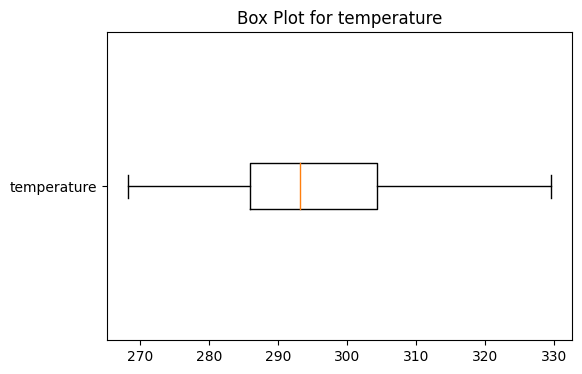

In [12]:
# Create a box plot to visualize outliers for the 'Temperature' variable
plt.figure(figsize=(6, 4))
plt.boxplot(NAM_df['temperature'], vert=False, labels=['temperature'])
plt.title("Box Plot for temperature")
plt.show()


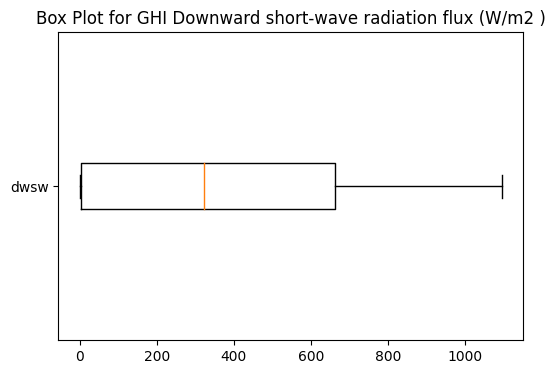

In [13]:
# Create a box plot to visualize outliers for the 'GHI Downward short-wave radiation flux (W/m2 )'
plt.figure(figsize=(6, 4))
plt.boxplot(NAM_df['dwsw'], vert=False, labels=['dwsw'])
plt.title("Box Plot for GHI Downward short-wave radiation flux (W/m2 )")
plt.show()


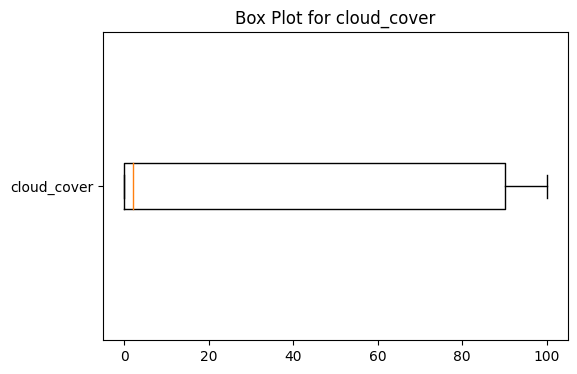

In [14]:
# Create a box plot to visualize outliers for the 'cloud_cover'
plt.figure(figsize=(6, 4))
plt.boxplot(NAM_df['cloud_cover'], vert=False, labels=['cloud_cover'])
plt.title("Box Plot for cloud_cover")
plt.show()


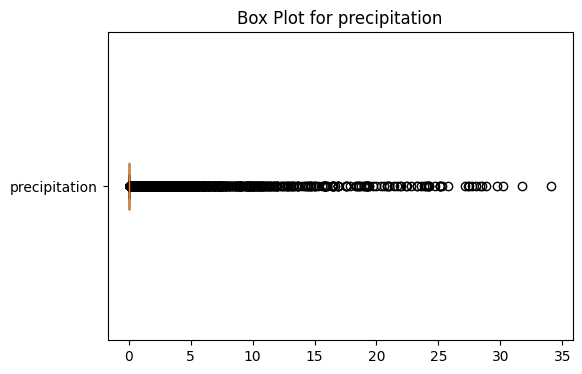

In [15]:
# Create a box plot to visualize outliers for the 'precipitation'
plt.figure(figsize=(6, 4))
plt.boxplot(NAM_df['precipitation'], vert=False, labels=['precipitation'])
plt.title("Box Plot for precipitation")
plt.show()


<Axes: >

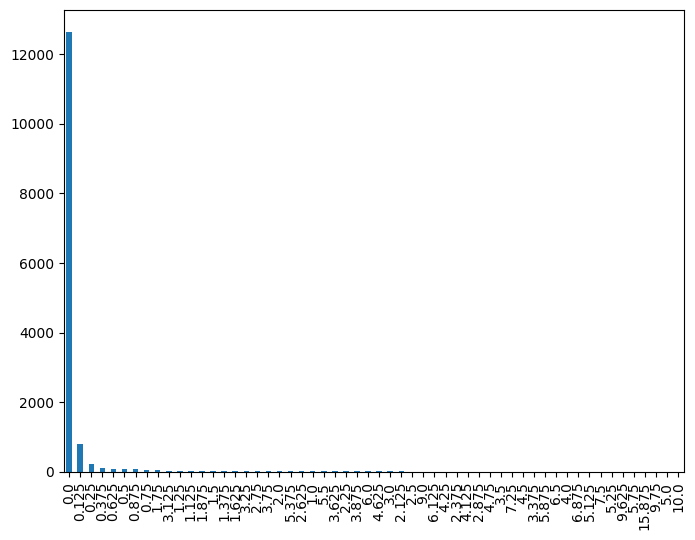

In [16]:
NAM_df.precipitation.value_counts()[:10].plot(kind='bar')

In [17]:
NAM_df = handle_outliers('precipitation',NAM_df)

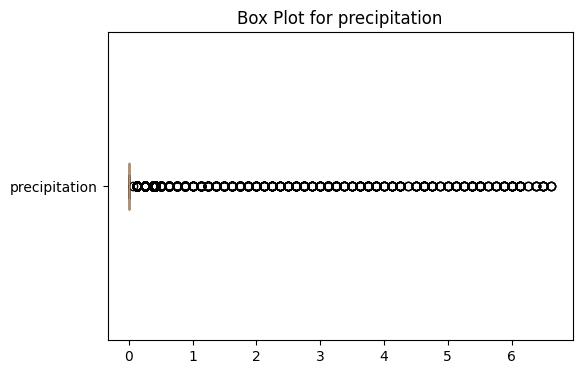

In [18]:
# Create a box plot to visualize outliers for the 'precipitation'
plt.figure(figsize=(6, 4))
plt.boxplot(NAM_df['precipitation'], vert=False, labels=['precipitation'])
plt.title("Box Plot for precipitation")
plt.show()


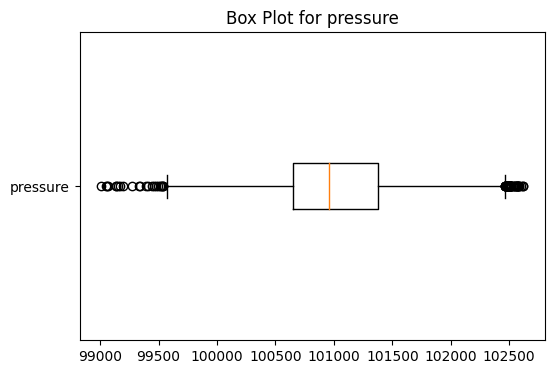

In [19]:
# Create a box plot to visualize outliers for the 'pressure'
plt.figure(figsize=(6, 4))
plt.boxplot(NAM_df['pressure'], vert=False, labels=['pressure'])
plt.title("Box Plot for pressure")
plt.show()


<Axes: >

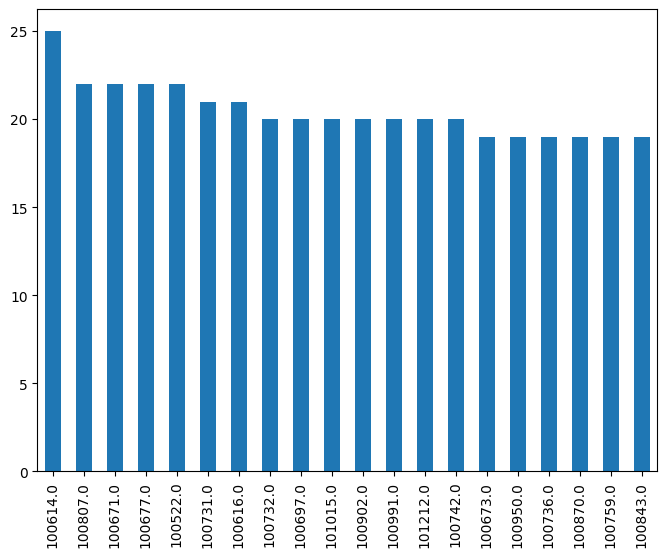

In [20]:
NAM_df.pressure.value_counts().head(20).plot(kind='bar')

Handling outliers in pressure
calculated IQR score to filter out the outliers by keeping only valid values

In [21]:
NAM_df = handle_outliers('pressure',NAM_df)

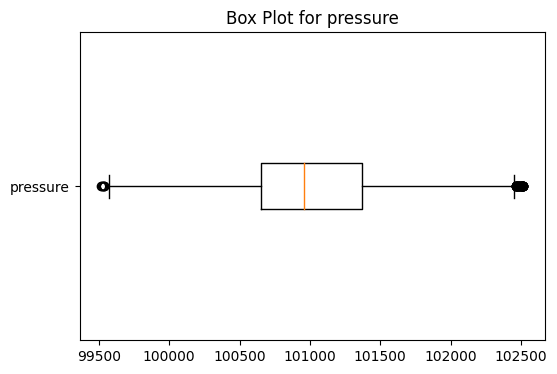

In [22]:
# Create a box plot to visualize outliers for the 'pressure'
plt.figure(figsize=(6, 4))
plt.boxplot(NAM_df['pressure'], vert=False, labels=['pressure'])
plt.title("Box Plot for pressure")
plt.show()


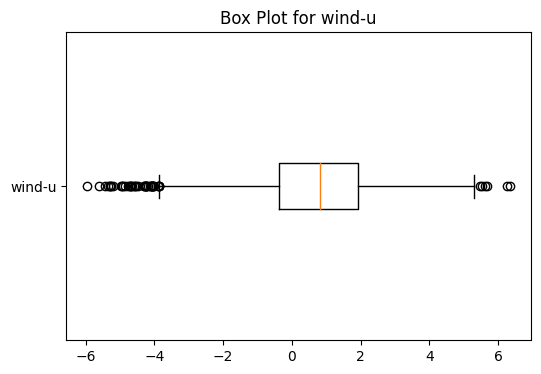

In [23]:
# Create a box plot to visualize outliers for the 'wind-u'
plt.figure(figsize=(6, 4))
plt.boxplot(NAM_df['wind-u'], vert=False, labels=['wind-u'])
plt.title("Box Plot for wind-u")
plt.show()

<Axes: >

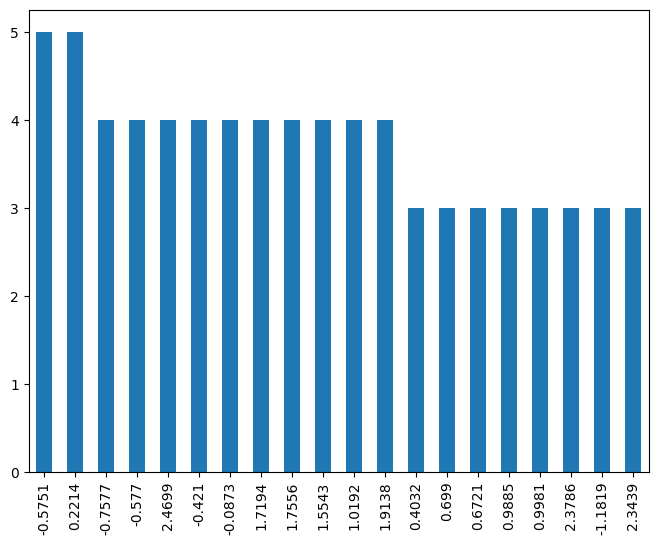

In [24]:
NAM_df['wind-u'].value_counts().head(20).plot(kind='bar')

In [25]:
NAM_df = handle_outliers('wind-u',NAM_df)

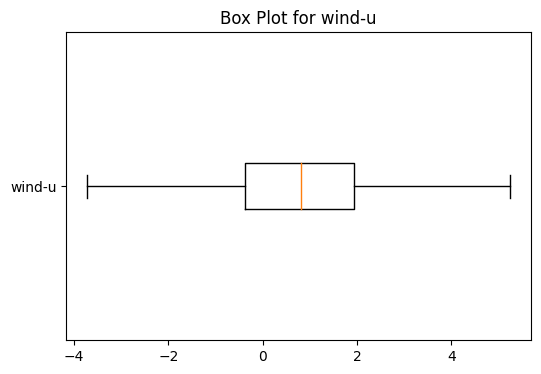

In [26]:
# Create a box plot to visualize outliers for the 'wind-u'
plt.figure(figsize=(6, 4))
plt.boxplot(NAM_df['wind-u'], vert=False, labels=['wind-u'])
plt.title("Box Plot for wind-u")
plt.show()

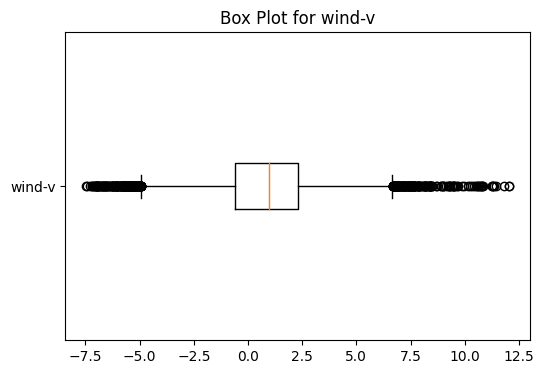

In [27]:
# Create a box plot to visualize outliers for the 'wind-v'
plt.figure(figsize=(6, 4))
plt.boxplot(NAM_df['wind-v'], vert=False, labels=['wind-v'])
plt.title("Box Plot for wind-v")
plt.show()


In [28]:
NAM_df = handle_outliers('wind-v',NAM_df)

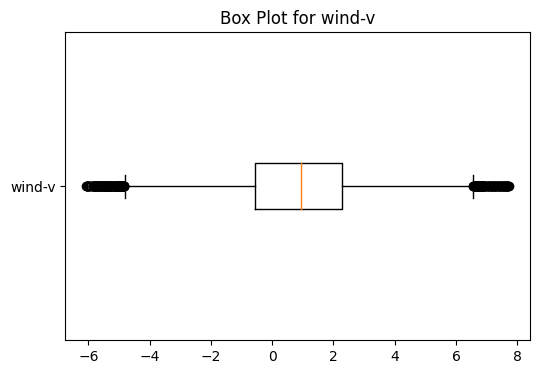

In [29]:
# Create a box plot to visualize outliers for the 'wind-v'
plt.figure(figsize=(6, 4))
plt.boxplot(NAM_df['wind-v'], vert=False, labels=['wind-v'])
plt.title("Box Plot for wind-v")
plt.show()

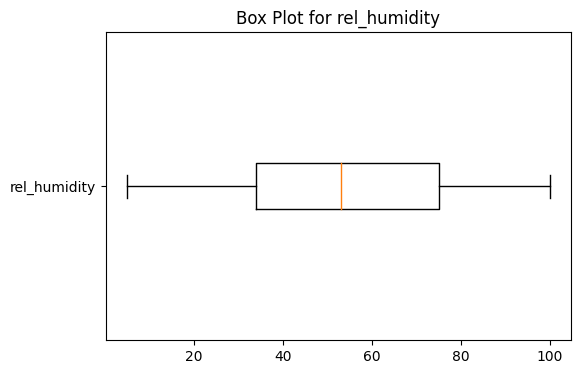

In [30]:
# Create a box plot to visualize outliers for the 'rel_humidity'
plt.figure(figsize=(6, 4))
plt.boxplot(NAM_df['rel_humidity'], vert=False, labels=['rel_humidity'])
plt.title("Box Plot for rel_humidity")
plt.show()

#### Feature Engineering

In [31]:
NAM_df['Year'] = pd.to_datetime(NAM_df['valtime']).dt.year
NAM_df['Month'] = pd.to_datetime(NAM_df['valtime']).dt.month
NAM_df['Day'] = pd.to_datetime(NAM_df['valtime']).dt.day
NAM_df['Hour'] = pd.to_datetime(NAM_df['valtime']).dt.hour
NAM_df['Minute'] = pd.to_datetime(NAM_df['valtime']).dt.minute

#### 2. Satellite imagery from GOES-15

Satellite imagery from GOES-15
Granularity: 15 Minute
Past Covariate
10 pixel by 10 pixel GOES-15 images centered in the target location.

In [32]:
satellite_imagery_data_path = tf.keras.utils.get_file(
    origin='https://zenodo.org/records/2826939/files/Folsom_satellite.csv?download=1',
    fname='Folsom_satellite.csv',
    extract=True)

15711562/15711562 [==============================] - 2s 0us/step


In [33]:
satellite_image_data = pd.read_csv(satellite_imagery_data_path,header=None,parse_dates=True)
satellite_image_features = pd.DataFrame(satellite_image_data[0]).rename(columns={0:'datetime'})
satellite_image_data = satellite_image_data.iloc[:,1:]
satellite_image_data

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,77,76,77,77,84,82,79,76,74,72,...,77,76,75,74,76,76,76,77,77,78
1,79,77,76,75,89,79,76,74,67,71,...,81,82,80,76,79,78,77,76,77,78
2,81,80,79,78,86,81,83,80,68,69,...,78,79,78,76,79,79,79,79,80,81
3,81,80,79,79,89,76,80,83,72,76,...,80,79,75,80,83,82,81,80,80,81
4,82,81,80,79,87,90,77,86,70,81,...,81,81,79,77,81,81,81,81,82,83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43056,146,151,156,160,164,163,161,160,159,159,...,162,165,167,166,164,162,160,159,160,163
43057,107,119,123,121,122,136,150,153,149,148,...,108,114,118,121,127,137,153,141,136,139
43058,121,124,121,142,143,145,144,141,142,147,...,111,115,118,116,136,136,152,164,153,143
43059,105,120,119,107,120,112,110,122,137,144,...,120,117,110,112,118,127,136,142,144,145


#### Feature Engineering

In [34]:
image = np.array(satellite_image_data.iloc[-1].tolist()).reshape(10,10)

In [35]:
image

array([[104, 105, 104, 102, 105, 105, 104, 110, 124, 139],
       [103, 105, 106, 105, 112, 113, 112, 116, 127, 140],
       [101, 105, 109, 112, 121, 124, 125, 127, 133, 141],
       [ 99, 104, 112, 118, 126, 132, 136, 136, 137, 142],
       [ 98, 103, 113, 123, 125, 134, 140, 139, 138, 141],
       [107,  99, 107, 134, 130, 134, 139, 141, 142, 144],
       [104,  98, 109, 136, 134, 134, 135, 138, 142, 145],
       [102,  97, 109, 137, 143, 140, 138, 142, 147, 150],
       [103,  97, 106, 130, 145, 145, 145, 146, 149, 150],
       [105,  99, 102, 119, 135, 141, 146, 146, 143, 142]])

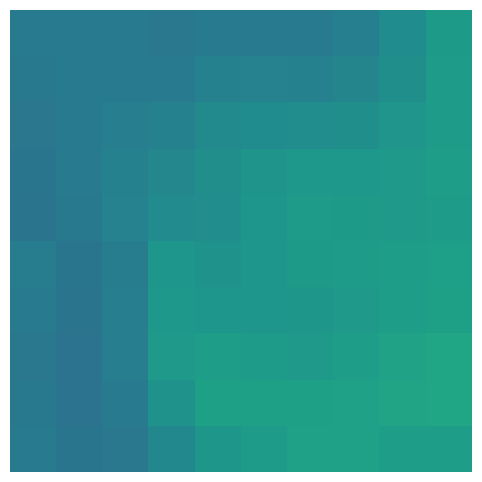

In [36]:
# Display the image using Matplotlib
plt.imshow(image, vmin=0, vmax=255)
plt.axis('off')  # Hide the axis
plt.show()

Calculating Cloud Cover Ratio from satellite image data with consideration of 120 as a threshold value

In [37]:
def Calculate_cloud_cover_ratio(image_matrics):
  image_matrics = image_matrics.tolist()
  cloud_count = len([i for i in image_matrics if i >=120])
  total_count = len(image_matrics)
  cloud_cover_ratio = cloud_count/total_count
  return cloud_cover_ratio

In [38]:
cloud_cover_ratio = satellite_image_data.transpose().apply(Calculate_cloud_cover_ratio)
satellite_image_features['cloud_cover_ratio'] = cloud_cover_ratio

In [39]:
# Calculate the average of each satellite_image
satellite_image_features['satellite_image_AVG'] = satellite_image_data.mean(axis=1)

In [40]:
# Calculate the STD of each satellite_image
satellite_image_features['satellite_image_STD'] = satellite_image_data.std(axis=1)

In [41]:
from scipy.stats import entropy

# Define a function to calculate entropy
def row_entropy(row):
    return entropy(row, base=2)  # Use base 2 for entropy calculation

# Calculate the Entropy is a measure of randomness or uncertainty of each satellite_image
satellite_image_features['satellite_image_ENT'] = satellite_image_data.iloc[:,1:].apply(row_entropy, axis=1)

In [42]:
satellite_image_features['Year'] = pd.to_datetime(satellite_image_features['datetime']).dt.year
satellite_image_features['Month'] = pd.to_datetime(satellite_image_features['datetime']).dt.month
satellite_image_features['Day'] = pd.to_datetime(satellite_image_features['datetime']).dt.day
satellite_image_features['Hour'] = pd.to_datetime(satellite_image_features['datetime']).dt.hour
satellite_image_features['Minute'] = pd.to_datetime(satellite_image_features['datetime']).dt.minute

In [43]:
satellite_image_features.shape

(43061, 10)

In [44]:
satellite_image_features['datetime']

0        2014-03-13 18:00:00
1        2014-03-13 18:45:00
2        2014-03-13 19:00:00
3        2014-03-13 19:15:00
4        2014-03-13 19:30:00
                ...         
43056    2016-12-31 21:00:00
43057    2016-12-31 21:45:00
43058    2016-12-31 22:15:00
43059    2016-12-31 23:15:00
43060    2016-12-31 23:30:00
Name: datetime, Length: 43061, dtype: object

In [45]:
satellite_image_features.head()

,datetime,cloud_cover_ratio,satellite_image_AVG,satellite_image_STD,satellite_image_ENT,Year,Month,Day,Hour,Minute
0,2014-03-13 18:00:00,0.0,76.91,4.204603,6.627170,2014,3,13,18,0
1,2014-03-13 18:45:00,0.0,78.17,5.323960,6.625966,2014,3,13,18,45
2,2014-03-13 19:00:00,0.0,79.45,4.639259,6.626857,2014,3,13,19,0
3,2014-03-13 19:15:00,0.0,80.77,5.794206,6.625568,2014,3,13,19,15
4,2014-03-13 19:30:00,0.0,81.95,6.072583,6.625217,2014,3,13,19,30


In [46]:
satellite_image_features.isnull().sum()

datetime               0
cloud_cover_ratio      0
satellite_image_AVG    0
satellite_image_STD    0
satellite_image_ENT    1
Year                   0
Month                  0
Day                    0
Hour                   0
Minute                 0
dtype: int64

In [47]:
satellite_image_features = satellite_image_features[~satellite_image_features.satellite_image_ENT.isnull()]

#### 3. sky camera imagery

- Imagery from Whole Sky Cameras
- Granularity: Minutely
- Past Covariate
- Features derived from the sky images.

In [48]:
# read sky imagery features
sky_image_features_csv_path = tf.keras.utils.get_file(
    origin='https://zenodo.org/records/2826939/files/Folsom_sky_image_features.csv?download=1',
    fname='Folsom_sky_image_features.csv',
    extract=False)
sky_image_features = pd.read_csv(sky_image_features_csv_path,parse_dates=True)
sky_image_features['timestamp'] = pd.to_datetime(sky_image_features['timestamp'])
sky_image_features.sort_values(by='timestamp', ascending=False, inplace=True)
sky_image_features

104681298/104681298 [==============================] - 5s 0us/step


,timestamp,AVG(R),STD(R),ENT(R),AVG(G),STD(G),ENT(G),AVG(B),STD(B),ENT(B),AVG(RB),STD(RB),ENT(RB),AVG(NRB),STD(NRB),ENT(NRB)
775915,2016-12-31 23:59:59,103.2748,62.9158,6.0814,115.6847,56.4043,6.0180,122.6635,45.1164,5.7957,0.7925,0.2410,5.2667,-0.1371,0.1596,4.6317
775914,2016-12-31 23:58:59,110.1486,61.0436,6.0823,116.9210,55.7548,6.0016,124.4827,45.2933,5.7811,0.8445,0.2123,5.1260,-0.0995,0.1323,4.4107
775913,2016-12-31 23:57:59,117.1289,59.2942,6.0814,119.1408,55.3043,6.0002,120.5959,45.5852,5.7543,0.9429,0.1899,5.0979,-0.0398,0.1066,4.2562
775912,2016-12-31 23:57:00,118.1933,59.0074,6.0942,119.7764,55.4268,6.0228,119.8126,46.1397,5.8002,0.9598,0.1788,5.0047,-0.0295,0.0987,4.1621
775911,2016-12-31 23:55:59,119.0850,58.5266,6.1185,120.1349,55.4199,6.0586,121.2516,46.8522,5.8533,0.9560,0.1625,4.8787,-0.0299,0.0901,4.0444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2014-01-01 00:04:11,106.7813,45.5549,5.6539,126.3533,39.0664,5.6438,137.2983,30.4596,5.4168,0.7541,0.1613,4.7906,-0.1494,0.1003,4.1823
3,2014-01-01 00:03:11,108.0799,46.3934,5.6447,129.5778,39.5050,5.6392,142.6288,30.9485,5.4369,0.7347,0.1625,4.8007,-0.1626,0.1034,4.2324
2,2014-01-01 00:02:10,118.4310,44.4158,5.6386,129.2313,39.1756,5.6381,134.9957,30.8004,5.4368,0.8591,0.1453,4.7299,-0.0822,0.0821,3.9662
1,2014-01-01 00:01:10,109.1193,44.9516,5.6762,128.0568,38.7453,5.6535,139.4049,30.2546,5.4146,0.7601,0.1547,4.7120,-0.1447,0.0953,4.0961


#### Feature Engineering

In [49]:
sky_image_features['Year'] = pd.to_datetime(sky_image_features['timestamp']).dt.year
sky_image_features['Month'] = pd.to_datetime(sky_image_features['timestamp']).dt.month
sky_image_features['Day'] = pd.to_datetime(sky_image_features['timestamp']).dt.day
sky_image_features['Hour'] = pd.to_datetime(sky_image_features['timestamp']).dt.hour
sky_image_features['Minute'] = pd.to_datetime(sky_image_features['timestamp']).dt.minute

In [50]:
sky_image_features.columns

Index(['timestamp', 'AVG(R)', 'STD(R)', 'ENT(R)', 'AVG(G)', 'STD(G)', 'ENT(G)',
       'AVG(B)', 'STD(B)', 'ENT(B)', 'AVG(RB)', 'STD(RB)', 'ENT(RB)',
       'AVG(NRB)', 'STD(NRB)', 'ENT(NRB)', 'Year', 'Month', 'Day', 'Hour',
       'Minute'],
      dtype='object')

# Global Horizontal Irradiance
This is the total solar radiation incident on a horizontal plane. This is the target for this project.

#### 4. irradiance features (Historical GHI)

In [51]:
# read irradiance features (Historical GHI)
irradiance_data_path = tf.keras.utils.get_file(
    origin='https://zenodo.org/records/2826939/files/Folsom_irradiance.csv?download=1',
    fname='Folsom_irradiance.csv',
    extract=False)
irradiance_data = pd.read_csv(irradiance_data_path)

76536976/76536976 [==============================] - 5s 0us/step


In [52]:
irradiance_data.head()

,timeStamp,ghi,dni,dhi
0,2014-01-02 08:00:00,0.0,0.0,0.0
1,2014-01-02 08:01:00,0.0,0.0,0.0
2,2014-01-02 08:02:00,0.0,0.0,0.0
3,2014-01-02 08:03:00,0.0,0.0,0.0
4,2014-01-02 08:04:00,0.0,0.0,0.0


In [53]:
irradiance_data = irradiance_data.drop(['dni','dhi'],axis=1)

In [54]:
irradiance_data['Year'] = pd.to_datetime(irradiance_data['timeStamp']).dt.year
irradiance_data['Month'] = pd.to_datetime(irradiance_data['timeStamp']).dt.month
irradiance_data['Day'] = pd.to_datetime(irradiance_data['timeStamp']).dt.day
irradiance_data['Hour'] = pd.to_datetime(irradiance_data['timeStamp']).dt.hour
irradiance_data['Minute'] = pd.to_datetime(irradiance_data['timeStamp']).dt.minute

Merge all features

In [55]:
NAM_df.columns

Index(['reftime', 'valtime', 'dwsw', 'cloud_cover', 'precipitation',
       'pressure', 'wind-u', 'wind-v', 'temperature', 'rel_humidity', 'Year',
       'Month', 'Day', 'Hour', 'Minute'],
      dtype='object')

In [56]:
NAM_df = NAM_df.drop(['reftime'],axis=1)

In [57]:
irradiance_data = irradiance_data.merge(NAM_df,on=['Year', 'Month', 'Day', 'Hour', 'Minute'], how='left')
irradiance_data = irradiance_data.fillna(method='bfill')
irradiance_data = irradiance_data[~irradiance_data.valtime.isnull()]

In [58]:
irradiance_data = irradiance_data.merge(satellite_image_features,on=['Year', 'Month', 'Day', 'Hour', 'Minute'], how='left')
irradiance_data = irradiance_data.fillna(method='bfill')

In [59]:
irradiance_data = irradiance_data.merge(sky_image_features,on=['Year', 'Month', 'Day', 'Hour', 'Minute'], how='left')
irradiance_data = irradiance_data.fillna(method='bfill')
irradiance_data = irradiance_data[~irradiance_data.timestamp.isnull()]

In [60]:
irradiance_data.isnull().sum()

timeStamp              0
ghi                    0
Year                   0
Month                  0
Day                    0
Hour                   0
Minute                 0
valtime                0
dwsw                   0
cloud_cover            0
precipitation          0
pressure               0
wind-u                 0
wind-v                 0
temperature            0
rel_humidity           0
datetime               0
cloud_cover_ratio      0
satellite_image_AVG    0
satellite_image_STD    0
satellite_image_ENT    0
timestamp              0
AVG(R)                 0
STD(R)                 0
ENT(R)                 0
AVG(G)                 0
STD(G)                 0
ENT(G)                 0
AVG(B)                 0
STD(B)                 0
ENT(B)                 0
AVG(RB)                0
STD(RB)                0
ENT(RB)                0
AVG(NRB)               0
STD(NRB)               0
ENT(NRB)               0
dtype: int64

In [61]:
irradiance_data = irradiance_data.drop(['valtime','datetime'],axis=1)

In [62]:
irradiance_data.shape

(1681392, 35)

In [63]:
irradiance_data.columns

Index(['timeStamp', 'ghi', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'dwsw',
       'cloud_cover', 'precipitation', 'pressure', 'wind-u', 'wind-v',
       'temperature', 'rel_humidity', 'cloud_cover_ratio',
       'satellite_image_AVG', 'satellite_image_STD', 'satellite_image_ENT',
       'timestamp', 'AVG(R)', 'STD(R)', 'ENT(R)', 'AVG(G)', 'STD(G)', 'ENT(G)',
       'AVG(B)', 'STD(B)', 'ENT(B)', 'AVG(RB)', 'STD(RB)', 'ENT(RB)',
       'AVG(NRB)', 'STD(NRB)', 'ENT(NRB)'],
      dtype='object')

 the evolution of irradiation over time

 **Assumption:** the time-series is “stationary”, which means that the time, does not affect the properties of the process under the statistical factor.

**stationarity** is required for statistics such as means, variances, and correlations to accurately describe the data at all time points of interest.


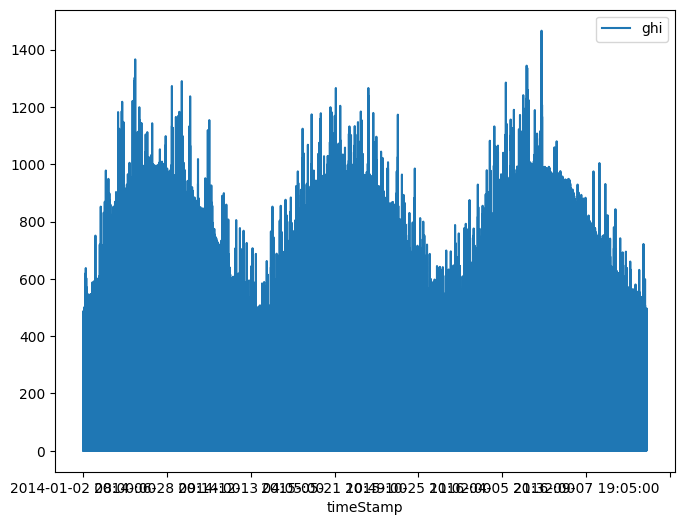

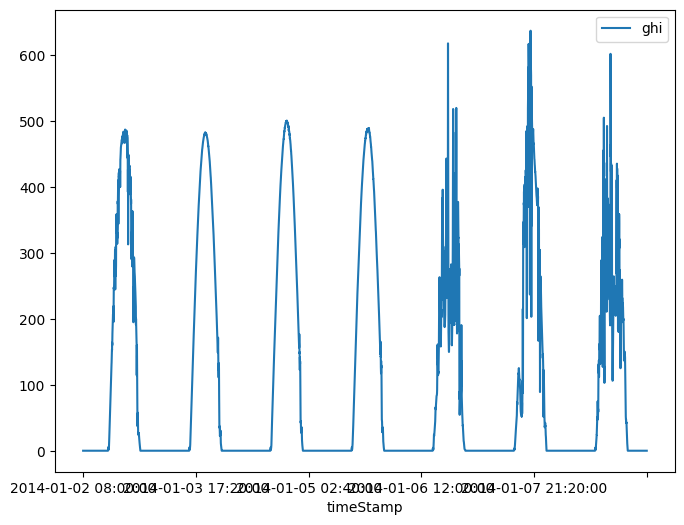

In [64]:
plot_cols = ['ghi']

plot_features = irradiance_data[plot_cols]
plot_features.index = irradiance_data['timeStamp']
_ = plot_features.plot(subplots=True)

plot_features = irradiance_data[plot_cols][:10000]
plot_features.index = irradiance_data['timeStamp'][:10000]
_ = plot_features.plot(subplots=True)

In [65]:
# Perform the ADF test
result = sm.tsa.adfuller(irradiance_data['ghi'].iloc[:10000], autolag='AIC')

# Extract and print the test statistics and p-value
adf_statistic, p_value, _, _, critical_values, _ = result
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')

# Compare the ADF Statistic to the critical values to determine stationarity
for key, value in critical_values.items():
    if adf_statistic < value:
        print(f"The ADF Statistic is smaller than the critical value at {key}. Reject the null hypothesis. The data is stationary.")
    else:
        print(f"The ADF Statistic is larger than the critical value at {key}. Fail to reject the null hypothesis. The data is non-stationary.")


ADF Statistic: -2.593843008671545
p-value: 0.09427648116348214
The ADF Statistic is larger than the critical value at 1%. Fail to reject the null hypothesis. The data is non-stationary.
The ADF Statistic is larger than the critical value at 5%. Fail to reject the null hypothesis. The data is non-stationary.
The ADF Statistic is smaller than the critical value at 10%. Reject the null hypothesis. The data is stationary.


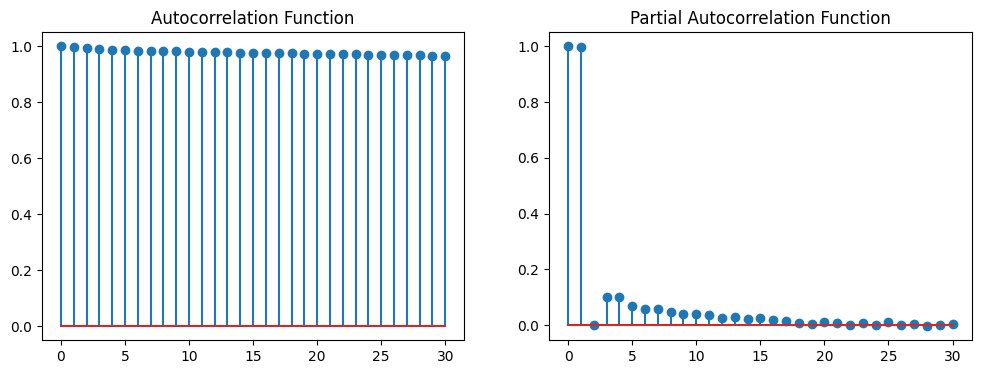

In [66]:
# Calculate ACF and PACF
lags = 30  # Number of lags to calculate
acf_values = acf(irradiance_data['ghi'], nlags=lags)
pacf_values = pacf(irradiance_data['ghi'], nlags=lags)

# Plot ACF
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.stem(acf_values)
plt.title('Autocorrelation Function')

# Plot PACF
plt.subplot(122)
plt.stem(pacf_values)
plt.title('Partial Autocorrelation Function')

plt.show()

array([<Axes: xlabel='timeStamp'>, <Axes: xlabel='timeStamp'>,
       <Axes: xlabel='timeStamp'>, <Axes: xlabel='timeStamp'>,
       <Axes: xlabel='timeStamp'>, <Axes: xlabel='timeStamp'>,
       <Axes: xlabel='timeStamp'>, <Axes: xlabel='timeStamp'>,
       <Axes: xlabel='timeStamp'>, <Axes: xlabel='timeStamp'>],
      dtype=object)

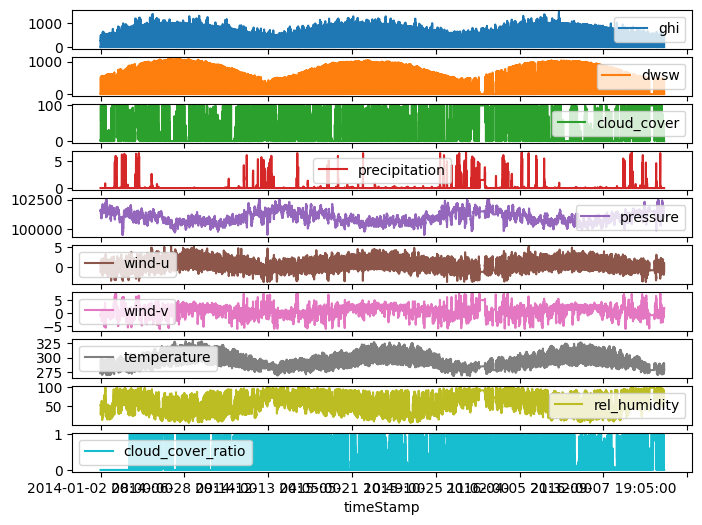

In [67]:
irradiance_data.set_index('timeStamp')[['ghi', 'dwsw','cloud_cover', 'precipitation', 'pressure', 'wind-u', 'wind-v',
       'temperature', 'rel_humidity', 'cloud_cover_ratio']].plot(subplots=True)

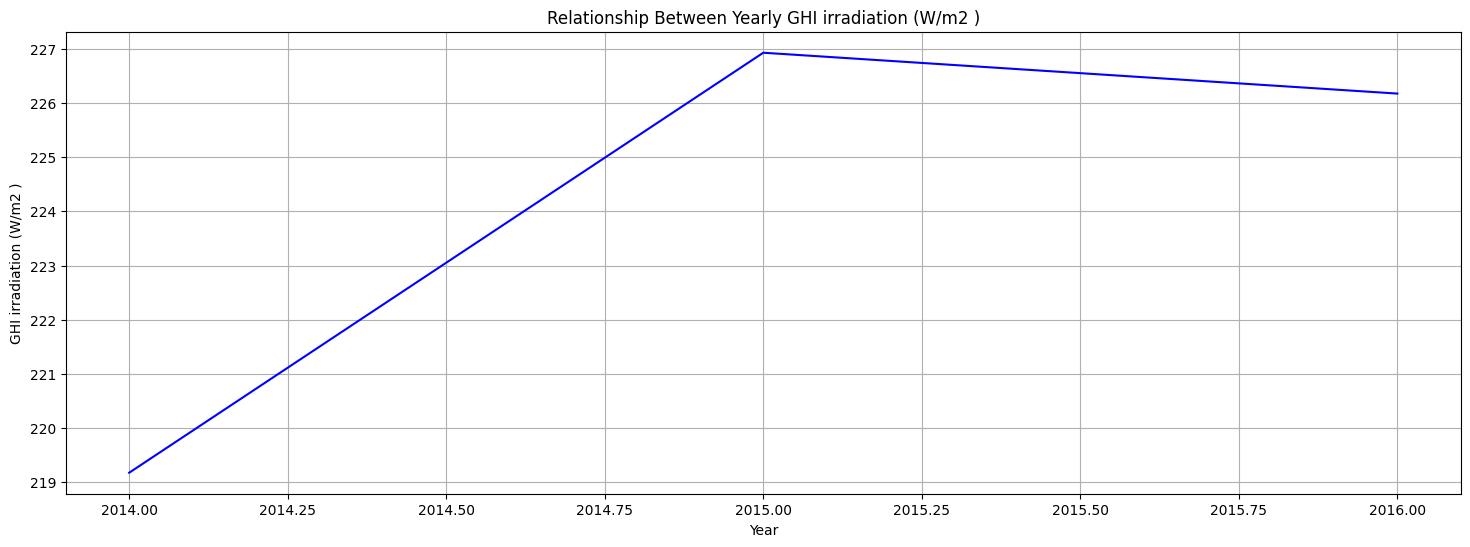

In [68]:
# Create a scatter plot to visualize the Yearly GHI irradiation (W/m2 )
plt.figure(figsize=(18, 6))
temp = irradiance_data.groupby(['Year']).mean()['ghi']
temp = temp.reset_index()
plt.plot(temp['Year'], temp['ghi'], color='blue')
plt.title("Relationship Between Yearly GHI irradiation (W/m2 )")
plt.xlabel("Year")
plt.ylabel("GHI irradiation (W/m2 )")
plt.grid(True)
plt.show()

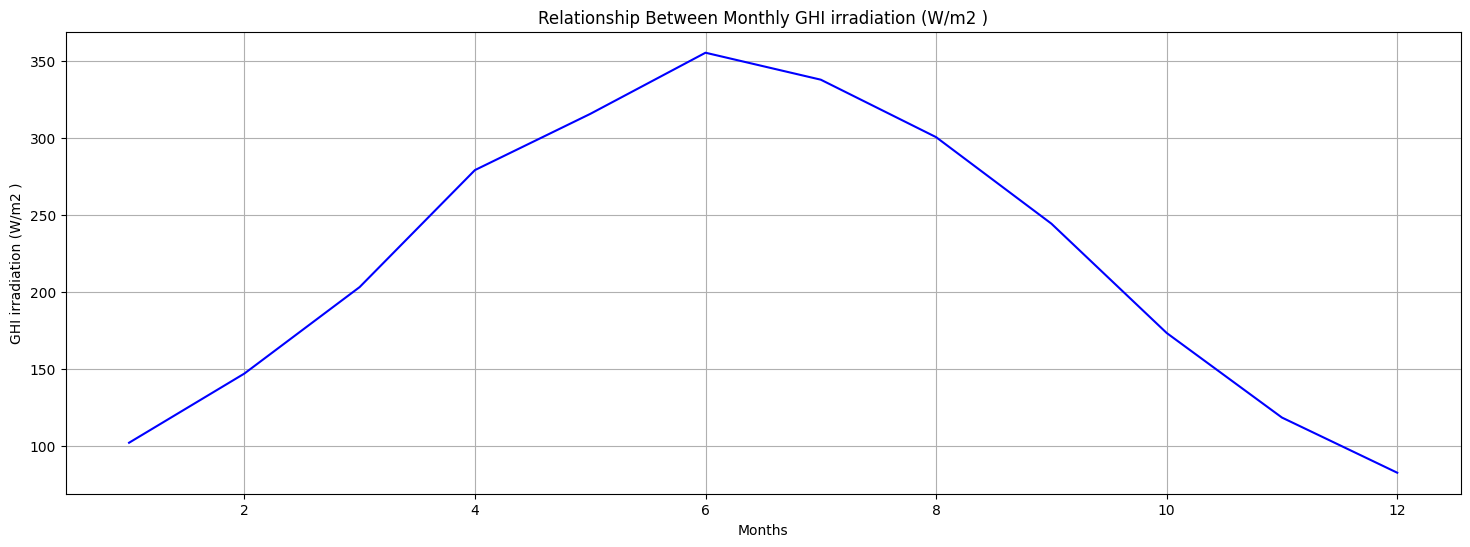

In [69]:
# Create a scatter plot to visualize the Monthly GHI irradiation (W/m2 )
plt.figure(figsize=(18, 6))
temp = irradiance_data.groupby(['Month']).mean()['ghi']
temp = temp.reset_index()
plt.plot(temp['Month'], temp['ghi'], color='blue')
plt.title("Relationship Between Monthly GHI irradiation (W/m2 )")
plt.xlabel("Months")
plt.ylabel("GHI irradiation (W/m2 )")
plt.grid(True)
plt.show()

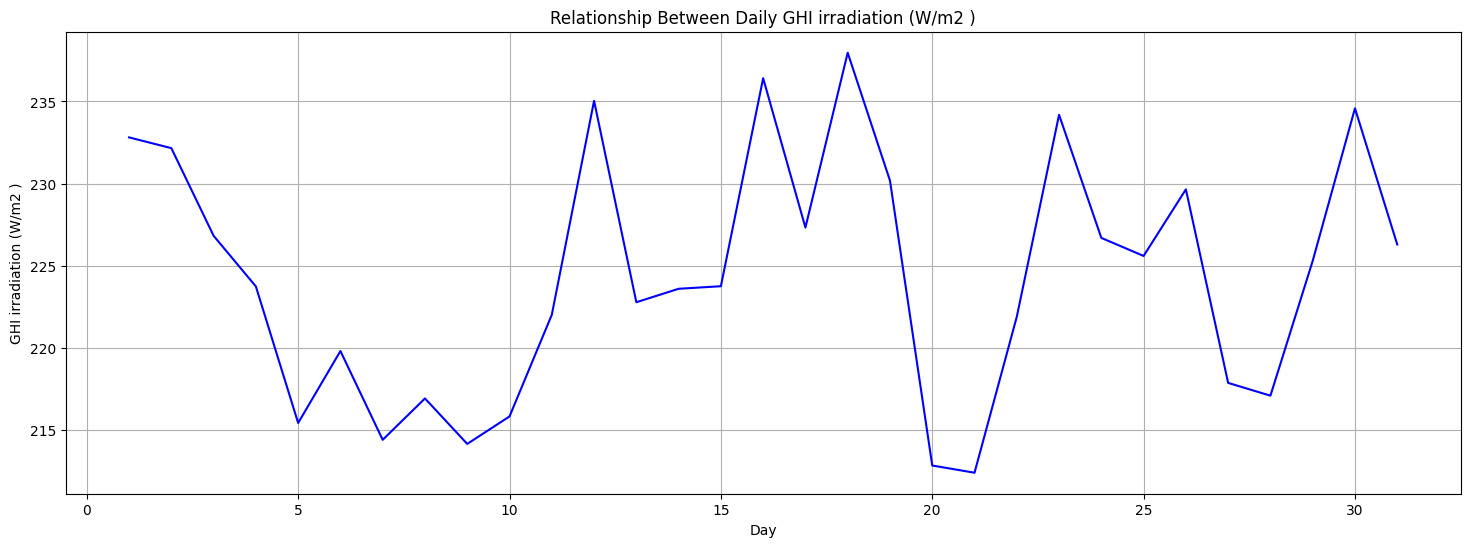

In [70]:
# Create a scatter plot to visualize the Daily GHI irradiation (W/m2 )
plt.figure(figsize=(18, 6))
temp = irradiance_data.groupby(['Day']).mean()['ghi']
temp = temp.reset_index()
plt.plot(temp['Day'], temp['ghi'], color='blue')
plt.title("Relationship Between Daily GHI irradiation (W/m2 )")
plt.xlabel("Day")
plt.ylabel("GHI irradiation (W/m2 )")
plt.grid(True)
plt.show()

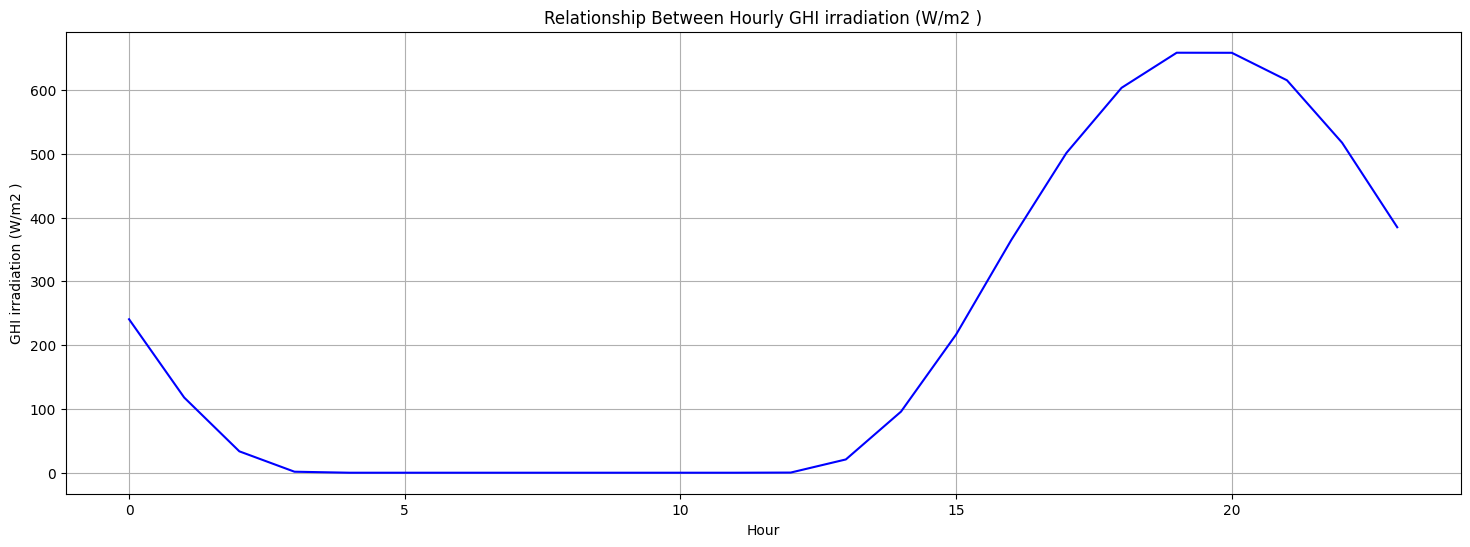

In [71]:
# Create a scatter plot to visualize the Hourly GHI irradiation (W/m2 )
plt.figure(figsize=(18, 6))
temp = irradiance_data.groupby(['Hour']).mean()['ghi']
temp = temp.reset_index()
plt.plot(temp['Hour'], temp['ghi'], color='blue')
plt.title("Relationship Between Hourly GHI irradiation (W/m2 )")
plt.xlabel("Hour")
plt.ylabel("GHI irradiation (W/m2 )")
plt.grid(True)
plt.show()

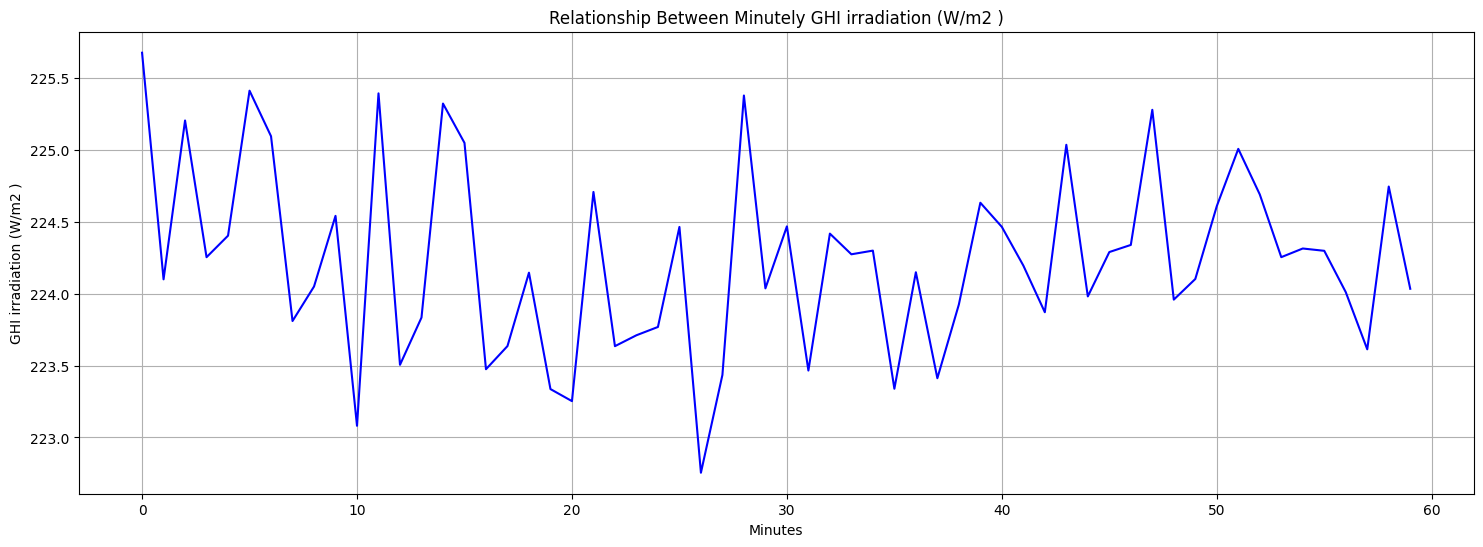

In [72]:
# Create a scatter plot to visualize the Minutely GHI irradiation (W/m2 )
plt.figure(figsize=(18, 6))
temp = irradiance_data.groupby(['Minute']).mean()['ghi']
temp = temp.reset_index()
plt.plot(temp['Minute'], temp['ghi'], color='blue')
plt.title("Relationship Between Minutely GHI irradiation (W/m2 )")
plt.xlabel("Minutes")
plt.ylabel("GHI irradiation (W/m2 )")
plt.grid(True)
plt.show()

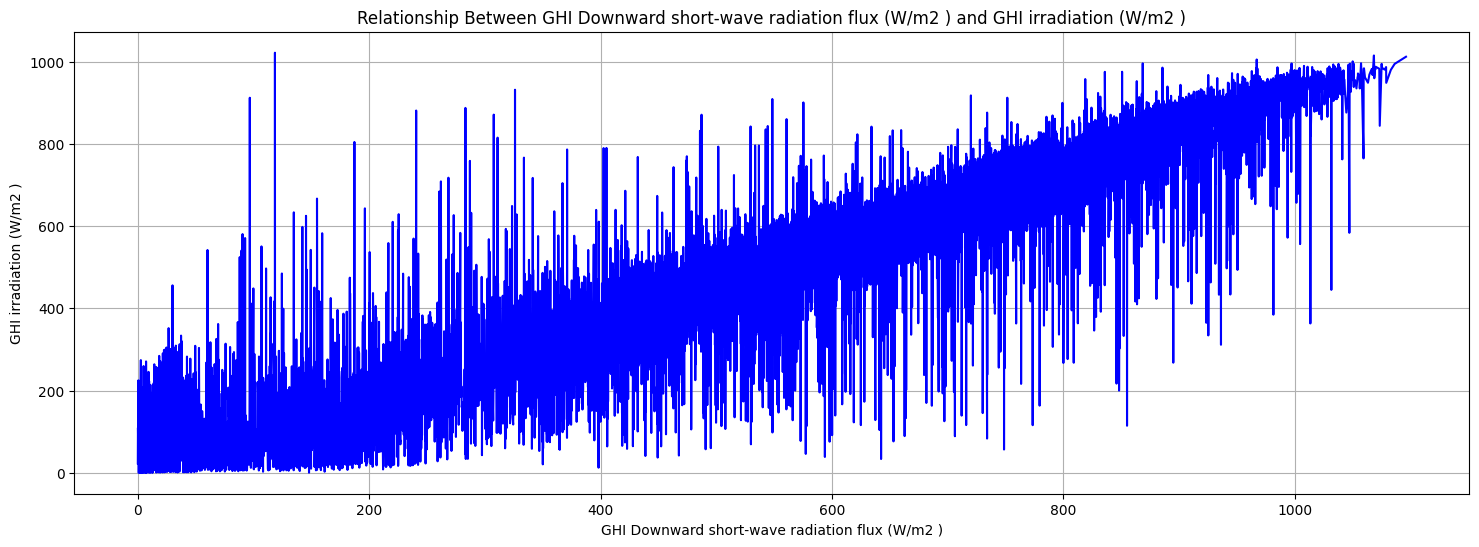

In [73]:
# Create a scatter plot to visualize the relationship between GHI Downward short-wave radiation flux (W/m2 ) and GHI irradiation (W/m2 )
plt.figure(figsize=(18, 6))
temp = irradiance_data.groupby(['dwsw']).mean()['ghi']
temp = temp.reset_index()
plt.plot(temp['dwsw'], temp['ghi'], color='blue')
plt.title("Relationship Between GHI Downward short-wave radiation flux (W/m2 ) and GHI irradiation (W/m2 )")
plt.xlabel("GHI Downward short-wave radiation flux (W/m2 )")
plt.ylabel("GHI irradiation (W/m2 )")
plt.grid(True)
plt.show()

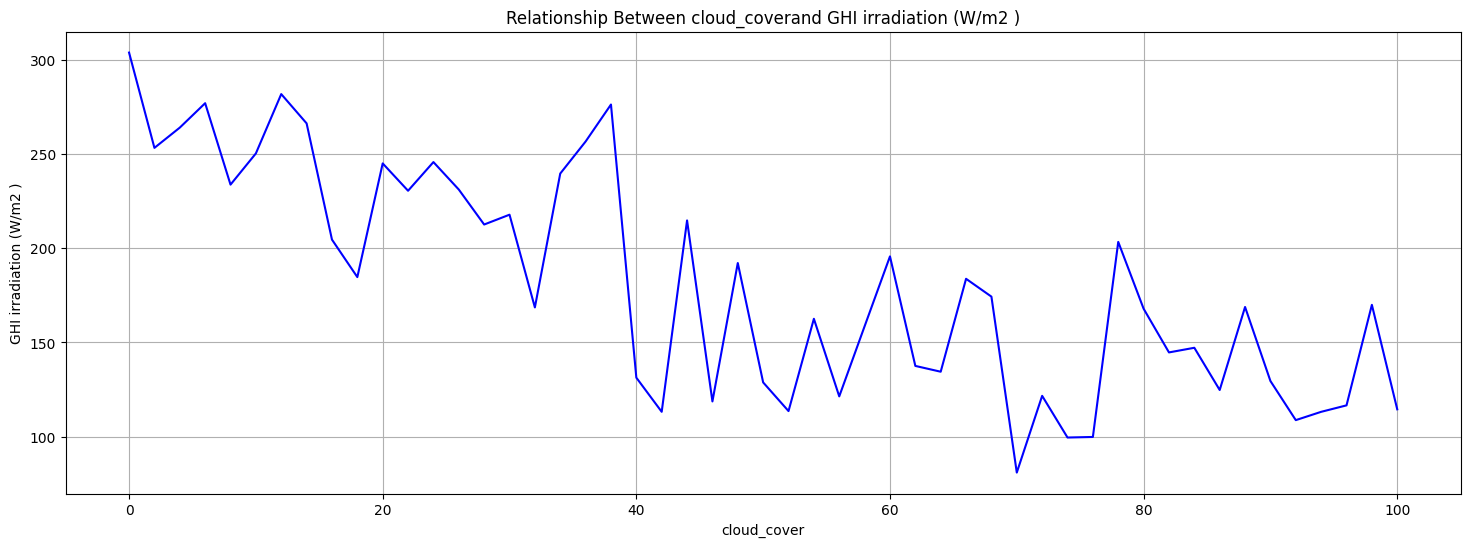

In [74]:
# Create a scatter plot to visualize the relationship between cloud_cover and GHI irradiation (W/m2 )
plt.figure(figsize=(18, 6))
temp = irradiance_data.groupby(['cloud_cover']).mean()['ghi']
temp = temp.reset_index()
plt.plot(temp['cloud_cover'], temp['ghi'], color='blue')
plt.title("Relationship Between cloud_coverand GHI irradiation (W/m2 )")
plt.xlabel("cloud_cover")
plt.ylabel("GHI irradiation (W/m2 )")
plt.grid(True)
plt.show()

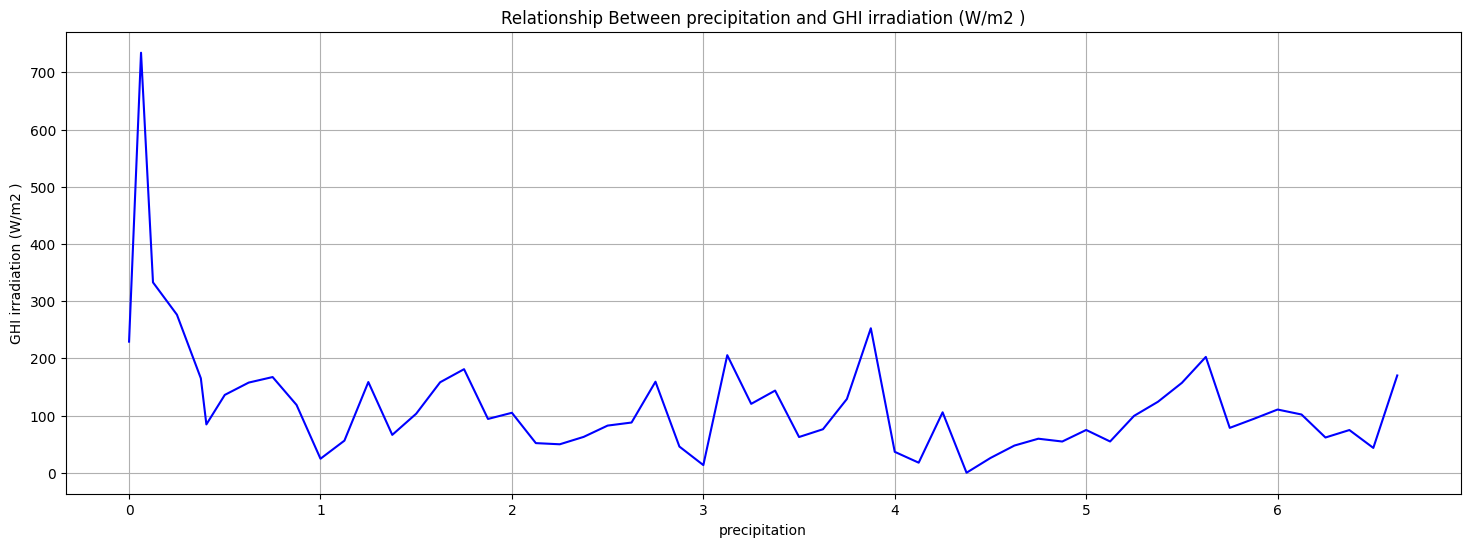

In [75]:
# Create a scatter plot to visualize the relationship between 'precipitation' and GHI irradiation (W/m2 )
plt.figure(figsize=(18, 6))
temp = irradiance_data.groupby(['precipitation']).mean()['ghi']
temp = temp.reset_index()
plt.plot(temp['precipitation'], temp['ghi'], color='blue')
plt.title("Relationship Between precipitation and GHI irradiation (W/m2 )")
plt.xlabel("precipitation")
plt.ylabel("GHI irradiation (W/m2 )")
plt.grid(True)
plt.show()

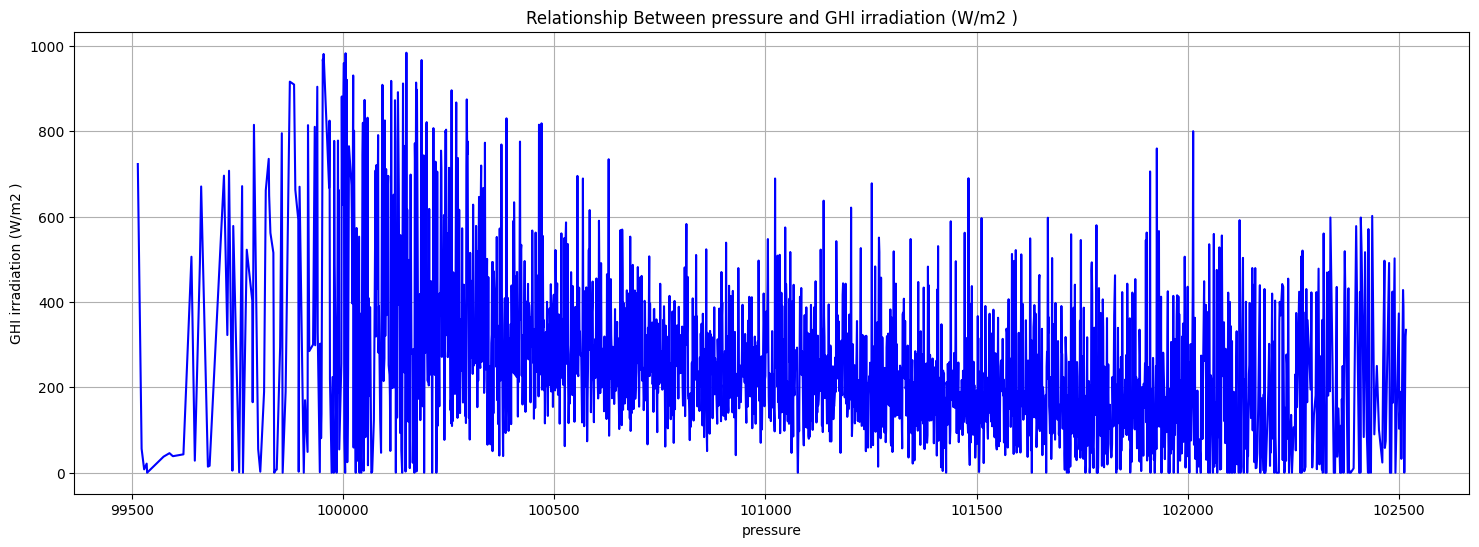

In [76]:
# Create a scatter plot to visualize the relationship between 'pressure' and GHI irradiation (W/m2 )
plt.figure(figsize=(18, 6))
temp = irradiance_data.groupby(['pressure']).mean()['ghi']
temp = temp.reset_index()
plt.plot(temp['pressure'], temp['ghi'], color='blue')
plt.title("Relationship Between pressure and GHI irradiation (W/m2 )")
plt.xlabel("pressure")
plt.ylabel("GHI irradiation (W/m2 )")
plt.grid(True)
plt.show()

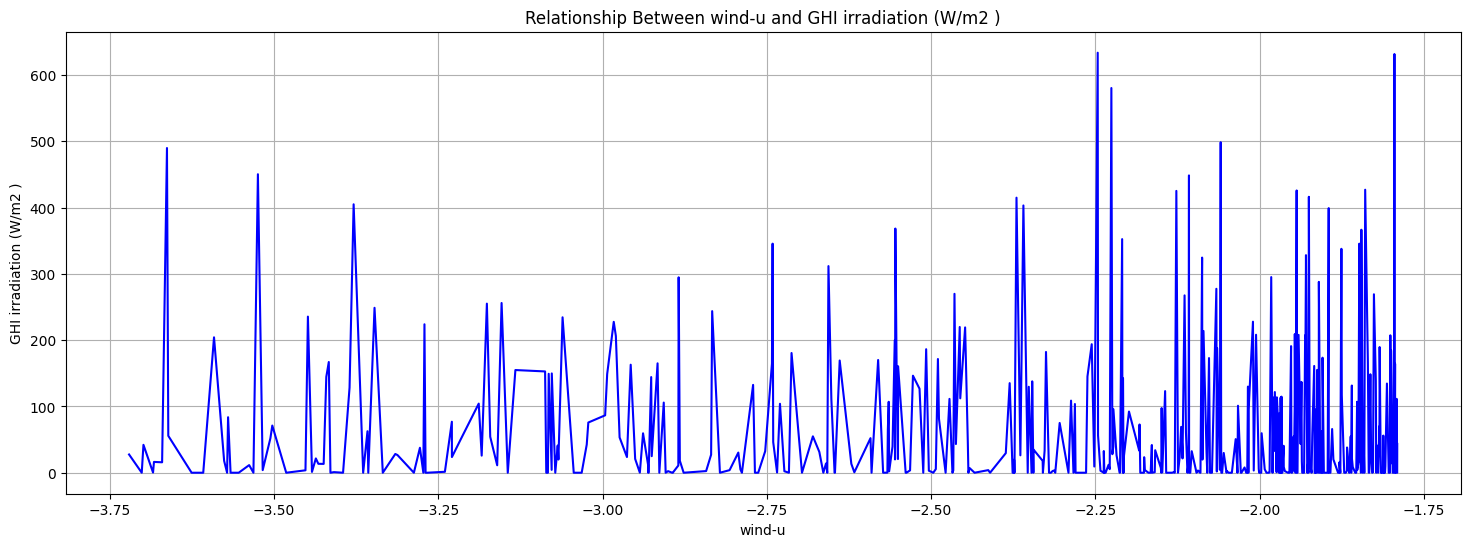

In [77]:
# Create a scatter plot to visualize the relationship between 'wind-u' and GHI irradiation (W/m2 )
plt.figure(figsize=(18, 6))
temp = irradiance_data.groupby(['wind-u']).mean()['ghi']
temp = temp.reset_index()
plt.plot(temp['wind-u'].iloc[:500], temp['ghi'].iloc[:500], color='blue')
plt.title("Relationship Between wind-u and GHI irradiation (W/m2 )")
plt.xlabel("wind-u")
plt.ylabel("GHI irradiation (W/m2 )")
plt.grid(True)
plt.show()

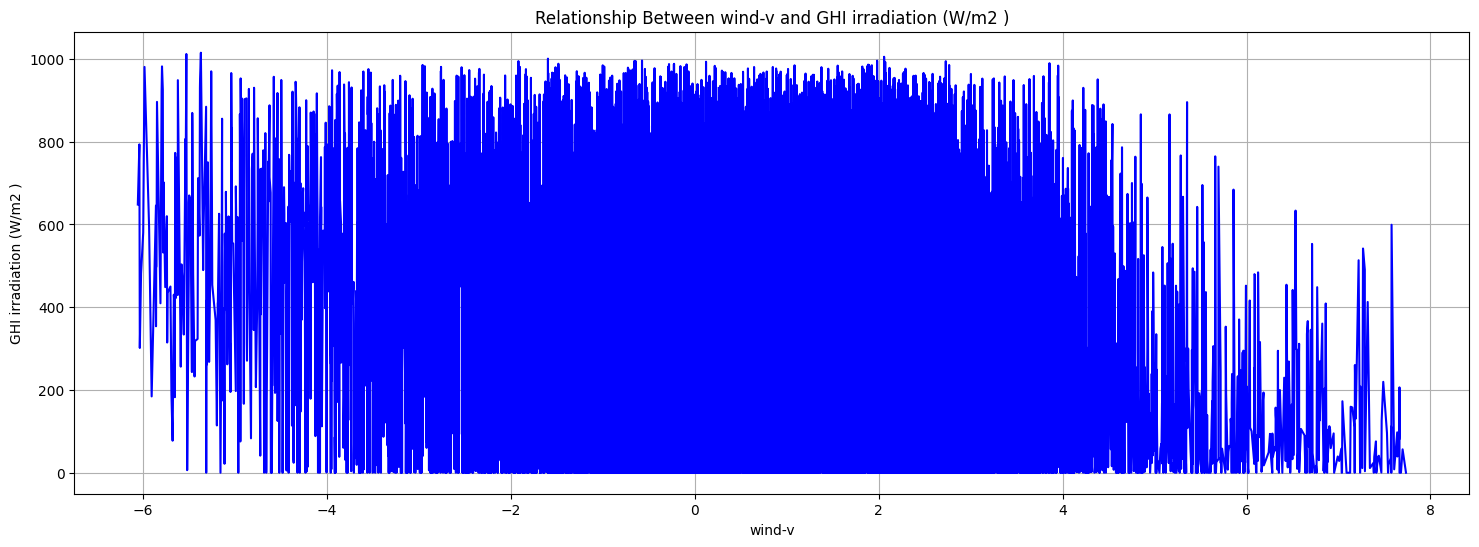

In [78]:
# Create a scatter plot to visualize the relationship between 'wind-v' and GHI irradiation (W/m2 )
plt.figure(figsize=(18, 6))
temp = irradiance_data.groupby(['wind-v']).mean()['ghi']
temp = temp.reset_index()
plt.plot(temp['wind-v'], temp['ghi'], color='blue')
plt.title("Relationship Between wind-v and GHI irradiation (W/m2 )")
plt.xlabel("wind-v")
plt.ylabel("GHI irradiation (W/m2 )")
plt.grid(True)
plt.show()

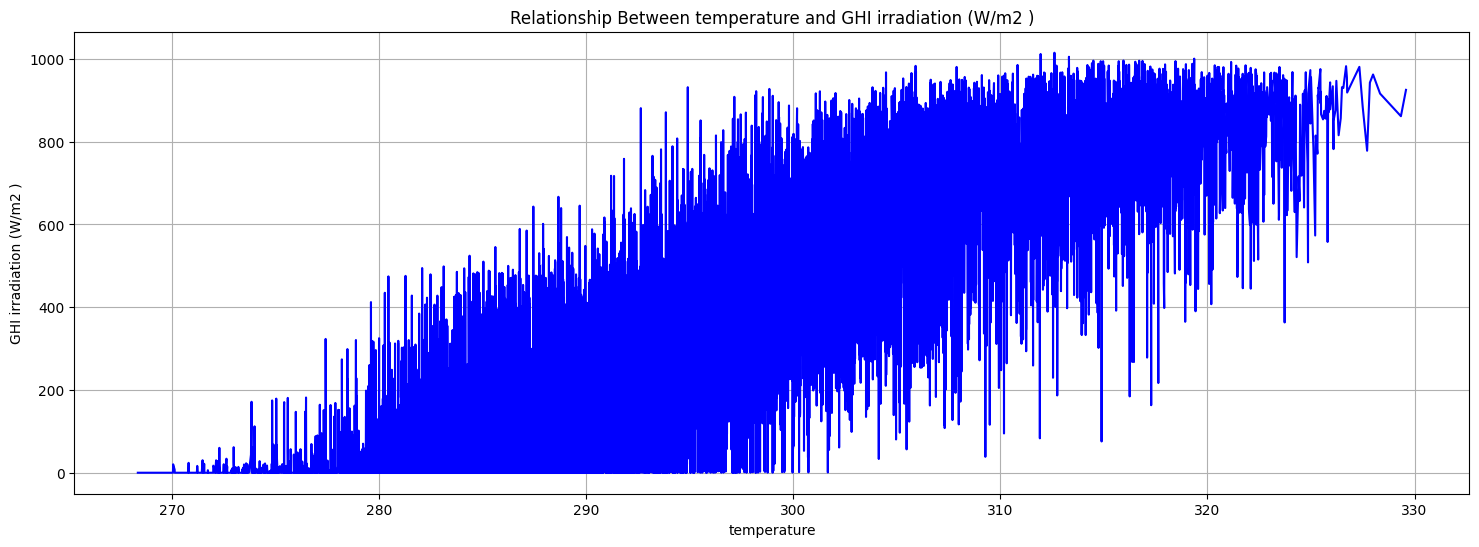

In [79]:
# Create a scatter plot to visualize the relationship between 'temperature' and GHI irradiation (W/m2 )
plt.figure(figsize=(18, 6))
temp = irradiance_data.groupby(['temperature']).mean()['ghi']
temp = temp.reset_index()
plt.plot(temp['temperature'], temp['ghi'], color='blue')
plt.title("Relationship Between temperature and GHI irradiation (W/m2 )")
plt.xlabel("temperature")
plt.ylabel("GHI irradiation (W/m2 )")
plt.grid(True)
plt.show()

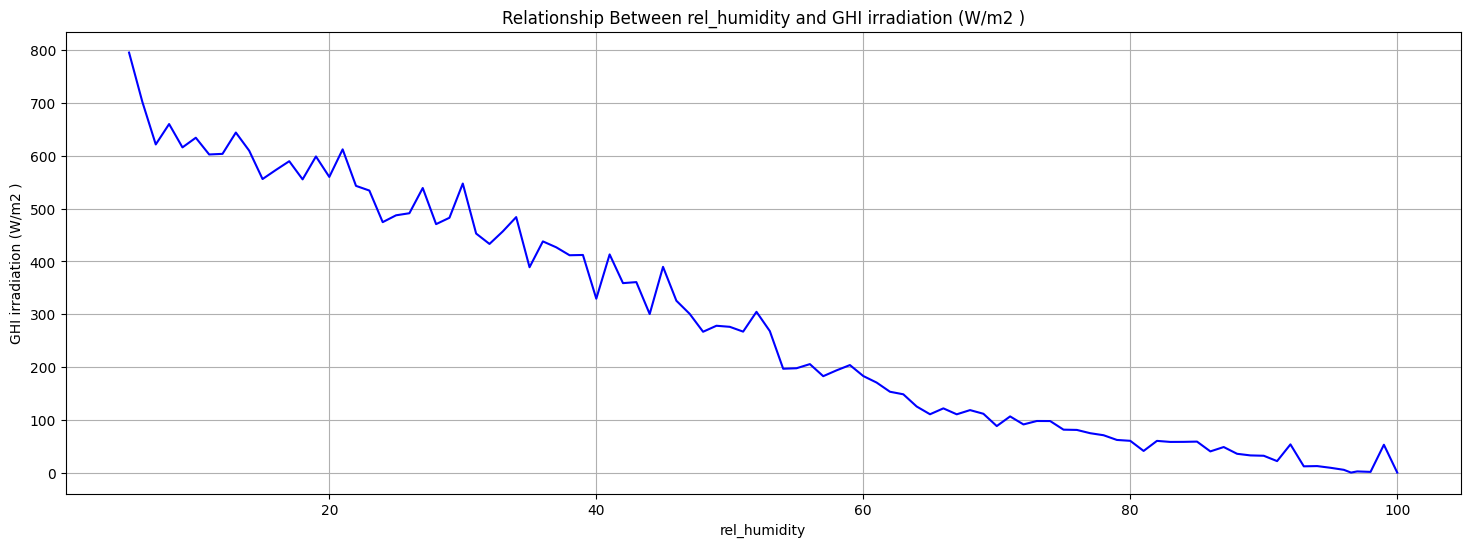

In [80]:
# Create a scatter plot to visualize the relationship between 'rel_humidity' and GHI irradiation (W/m2 )
plt.figure(figsize=(18, 6))
temp = irradiance_data.groupby(['rel_humidity']).mean()['ghi']
temp = temp.reset_index()
plt.plot(temp['rel_humidity'], temp['ghi'], color='blue')
plt.title("Relationship Between rel_humidity and GHI irradiation (W/m2 )")
plt.xlabel("rel_humidity")
plt.ylabel("GHI irradiation (W/m2 )")
plt.grid(True)
plt.show()

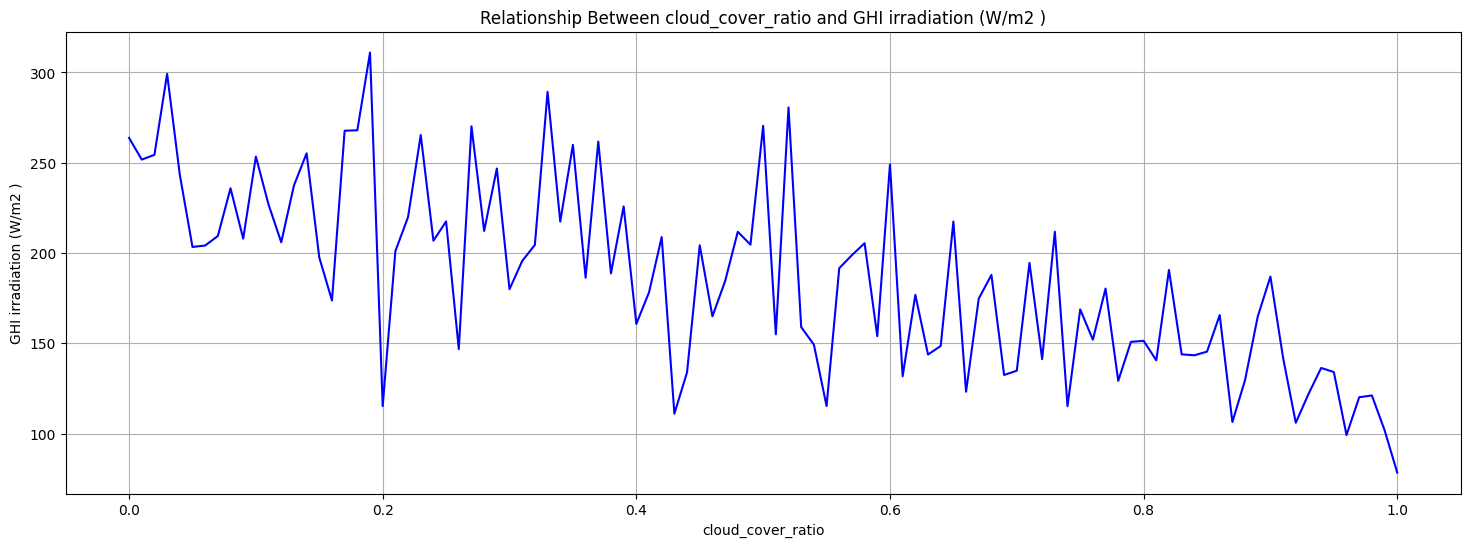

In [81]:
# Create a scatter plot to visualize the relationship between 'cloud_cover_ratio' and GHI irradiation (W/m2 )
plt.figure(figsize=(18, 6))
temp = irradiance_data.groupby(['cloud_cover_ratio']).mean()['ghi']
temp = temp.reset_index()
plt.plot(temp['cloud_cover_ratio'], temp['ghi'], color='blue')
plt.title("Relationship Between cloud_cover_ratio and GHI irradiation (W/m2 )")
plt.xlabel("cloud_cover_ratio")
plt.ylabel("GHI irradiation (W/m2 )")
plt.grid(True)
plt.show()

In [82]:
irradiance_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ghi,1681392.0,224.232459,300.471724,0.000000,0.000000,26.220000,425.200000,1466.000000
Year,1681392.0,2015.031369,0.811407,2014.000000,2014.000000,2015.000000,2016.000000,2016.000000
Month,1681392.0,6.558331,3.406000,1.000000,4.000000,7.000000,10.000000,12.000000
Day,1681392.0,15.767085,8.775823,1.000000,8.000000,16.000000,23.000000,31.000000
Hour,1681392.0,11.809800,6.993417,0.000000,6.000000,12.000000,18.000000,23.000000
Minute,1681392.0,29.502997,17.320146,0.000000,14.000000,30.000000,45.000000,59.000000
dwsw,1681392.0,237.876746,318.801561,0.000000,0.000000,38.375000,457.375000,1096.240000
cloud_cover,1681392.0,37.015468,43.811889,0.000000,0.000000,4.000000,98.000000,100.000000
precipitation,1681392.0,0.154930,0.665211,0.000000,0.000000,0.000000,0.000000,6.625000
pressure,1681392.0,101019.196946,495.335803,99514.000000,100648.000000,100957.000000,101378.000000,102517.000000


In [83]:
corr = irradiance_data.corr()
corr['ghi']

ghi                    1.000000
Year                   0.009259
Month                 -0.043096
Day                    0.002721
Hour                   0.633368
Minute                -0.000131
dwsw                   0.916681
cloud_cover           -0.274017
precipitation         -0.085336
pressure              -0.171660
wind-u                 0.670190
wind-v                -0.151360
temperature            0.808999
rel_humidity          -0.612791
cloud_cover_ratio     -0.227908
satellite_image_AVG   -0.336958
satellite_image_STD    0.254527
satellite_image_ENT   -0.071778
AVG(R)                -0.475698
STD(R)                 0.552316
ENT(R)                 0.427486
AVG(G)                -0.551507
STD(G)                 0.538266
ENT(G)                 0.374244
AVG(B)                -0.418788
STD(B)                 0.420307
ENT(B)                 0.234304
AVG(RB)               -0.299649
STD(RB)                0.237732
ENT(RB)                0.346472
AVG(NRB)              -0.280415
STD(NRB)

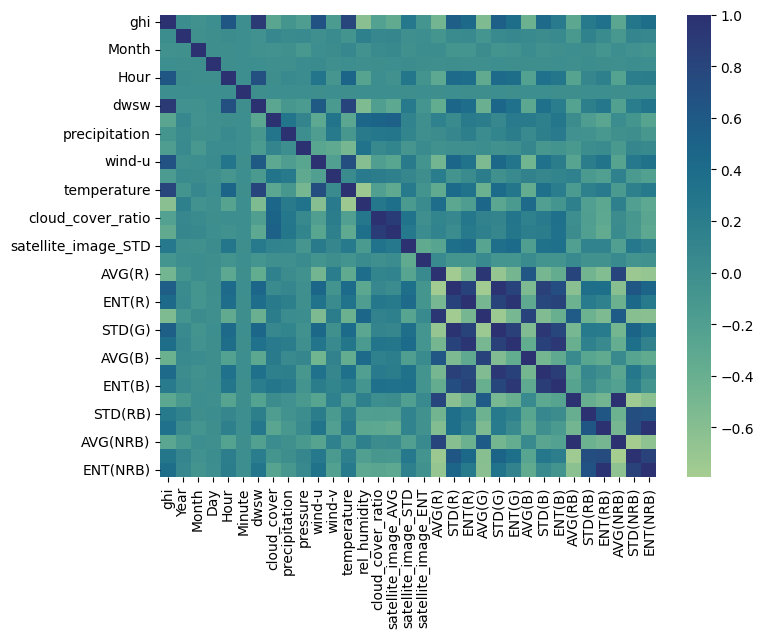

In [84]:
sns.heatmap(corr,cmap="crest")
plt.show()

In [85]:
irradiance_data.shape

(1681392, 35)

In [86]:
irradiance_data.timeStamp.duplicated().sum()

129504

In [87]:
# Convert the 'Date' column to a datetime type
irradiance_data['timeStamp'] = pd.to_datetime(irradiance_data['timeStamp'])

# Group by 'Date' and calculate the mean values for all numeric columns
processed_df = irradiance_data.groupby('timeStamp').mean().reset_index()

In [88]:
processed_df.to_csv("/content/drive/MyDrive/Folsom_sky_images/processed_data.csv",index=False)

In [89]:
processed_df.shape

(1551888, 34)

In [90]:
processed_df.timeStamp.duplicated().sum()

0